Imports

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
import pickle
import sys

In [2]:
import tensorflow as tf
tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [2]:
# Function to show various error measurement
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = np.mean((forecast - actual)**2)  # MSE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mmape = np.mean(np.abs(forecast - actual) / np.abs(forecast)) # modified mape
    #corr = np.corrcoef(forecast, actual)[0,1]   # corr
    #mins = np.amin(np.hstack([forecast[:,None], 
    #                          actual[:,None]]), axis=1)
    #maxs = np.amax(np.hstack([forecast[:,None], 
    #                          actual[:,None]]), axis=1)
    #minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    #return({'mape':mape, 'me':me, 'mae': mae, 
    #        'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
    #        'corr':corr, 'minmax':minmax})
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'mse':mse, 'rmse':rmse, 'mmape': mmape})

In [5]:
import os
os.chdir('d:/Users/mokky/Documents/GitHub/nus-iss/PRS-PM-ISY5002-GROUP5/SystemCode')
print(os.getcwd())

d:\Users\mokky\Documents\GitHub\nus-iss\PRS-PM-ISY5002-GROUP5\SystemCode


In [3]:
file_dir = './Data Exploration/data/uc3/'
X_train_file_path = 'all_hosp_new_train_X_uc3.pkl'
y_train_file_path = 'all_hosp_data_uc3_y_train_uc3.pkl'
X_test_file_path = 'all_hosp_new_test_X_uc3.pkl'
y_test_file_path = 'all_hosp_data_uc3_y_test_uc3.pkl'

In [6]:
df_X_train = pd.read_pickle(file_dir + X_train_file_path)
df_y_train = pd.read_pickle(file_dir + y_train_file_path)
df_X_test = pd.read_pickle(file_dir + X_test_file_path)
df_y_test = pd.read_pickle(file_dir + y_test_file_path)
print(df_X_train.shape, df_y_train.shape, df_X_test.shape, df_y_test.shape)

(46888, 14313) (46888,) (15629, 14313) (15629,)


In [7]:
print(df_y_test.values.shape)

(15629,)


Neural Networks ( Sequential )

In [8]:
NN_model = Sequential()
n_hid_nodes = 4096
dropout_rate = 0.2
rand_seed = 42
kernel_init = 'he_normal'
hid_act = 'relu'

In [9]:
NN_model.add(Dense(n_hid_nodes, kernel_initializer=kernel_init,input_dim = df_X_train.shape[1], activation=hid_act))
NN_model.add(Dropout(dropout_rate, seed=rand_seed))

In [10]:
#NN_model.add(GaussianNoise(0.01,input_shape = (df_X_train.shape[1],)))
#NN_model.add(Dense(n_hid_nodes, kernel_initializer=kernel_init,activation='relu'))
#NN_model.add(Dropout(dropout_rate, seed=rand_seed))

In [11]:
for i in range(2):
    NN_model.add(Dense(n_hid_nodes, kernel_initializer=kernel_init))#,activation=hid_act))
    NN_model.add(BatchNormalization())
    NN_model.add(Activation(hid_act))
    NN_model.add(Dropout(dropout_rate, seed=rand_seed))

In [12]:
NN_model.add(Dense(1, kernel_initializer=kernel_init,activation='linear'))

In [13]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              58630144  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
activation (Activation)      (None, 4096)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              1

In [14]:
checkpoint_name = 'NN2_Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
callbacks_list = [es, checkpoint]

In [15]:
NN_model.fit(df_X_train, df_y_train, epochs=100, batch_size=128, validation_split = 0.2, callbacks=callbacks_list)

# save model to file
NN_model.save(file_dir + "uc3_NN2_model.h5")

Train on 37510 samples, validate on 9378 samples
Epoch 1/100
37504/37510 [============================>.] - ETA: 0s - loss: 6270.3791 - mean_absolute_error: 6270.3799
Epoch 00001: val_loss improved from inf to 5460.40301, saving model to NN2_Weights-001--5460.40301.hdf5
37510/37510 [==============================] - 58s 2ms/sample - loss: 6271.5757 - mean_absolute_error: 6271.5767 - val_loss: 5460.4030 - val_mean_absolute_error: 5460.4028
Epoch 2/100
37504/37510 [============================>.] - ETA: 0s - loss: 4409.9712 - mean_absolute_error: 4409.9722
Epoch 00002: val_loss improved from 5460.40301 to 2673.03832, saving model to NN2_Weights-002--2673.03832.hdf5
37510/37510 [==============================] - 56s 1ms/sample - loss: 4410.0633 - mean_absolute_error: 4410.0645 - val_loss: 2673.0383 - val_mean_absolute_error: 2673.0388
Epoch 3/100
37504/37510 [============================>.] - ETA: 0s - loss: 2591.0017 - mean_absolute_error: 2591.0015
Epoch 00003: val_loss improved from 26

In [16]:
predictions = NN_model.predict(df_X_test)

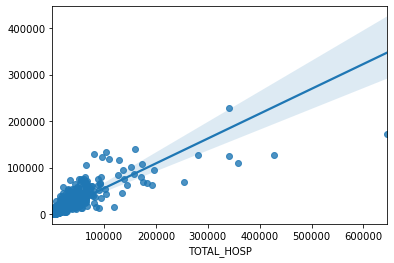

In [17]:
sns.regplot(x=df_y_test, y=predictions)

In [18]:
# MSE
print('Mean squared error: %.2f'
      % mean_squared_error(df_y_test,predictions, squared=True))

# RMSE
print('Root Mean squared error: %.2f'
      % mean_squared_error(df_y_test,predictions, squared=False))

# MAE
print('Mean absolute error: %.2f'
      % mean_absolute_error(df_y_test,predictions))

Mean squared error: 50660855.39
Root Mean squared error: 7117.64
Mean absolute error: 1808.46


In [19]:
forecast_accuracy(predictions.reshape((-1,)), df_y_test)

{'mape': 0.28837315690407184,
 'me': -637.7351468577169,
 'mae': 1808.4606558727216,
 'mpe': 0.0626254968571037,
 'mse': 50660855.39250669,
 'rmse': 7117.643949545853}

In [8]:
df_X_test = pd.read_pickle(file_dir + X_test_file_path)
df_y_test = pd.read_pickle(file_dir + y_test_file_path)
model = load_model(file_dir + "uc3_NN2_model.h5")
y_pred = model.predict(df_X_test)
forecast_accuracy(y_pred.reshape((-1,)), df_y_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


{'mape': 0.28837315690407184,
 'me': -637.7351468577169,
 'mae': 1808.4606558727216,
 'mpe': 0.0626254968571037,
 'mse': 50660855.39250669,
 'rmse': 7117.643949545853,
 'mmape': 0.2824793331206611}